In [ ]:
# %% Load data and packages

#environment: amd 2nodes 60G 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from prophet import Prophet
from scipy.stats import gaussian_kde


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)

# Note potentially relevant features like danceability, energy, acousticness, etc.
print(df.columns)
print("Number of rows before filtering:", df.count())

feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

24/11/27 13:27:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
['id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist']


Number of rows before filtering: 745785


In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行

'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 741255


Number of rows within 1921-2020: 731971


ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
'''
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行
'''
'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 731971


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
'''
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行
'''
'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 731971


Number of rows within 1921-2020: 731971


"\n['id',\n 'name',\n 'popularity',\n 'duration_ms',\n 'explicit', #ignore\n 'release_date',\n 'danceability',\n 'energy',\n 'key',\n 'loudness',\n 'mode',\n 'speechiness',\n 'acousticness',\n 'instrumentalness',\n 'liveness',#ignore\n 'valence',\n 'tempo',\n 'time_signature',\n 'artist']\n "

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

root
 |-- features: vector (nullable = true)



In [ ]:
# %% Load data and packages

#environment: amd 2nodes 60G 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from prophet import Prophet
from scipy.stats import gaussian_kde


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)

# Note potentially relevant features like danceability, energy, acousticness, etc.
print(df.columns)
print("Number of rows before filtering:", df.count())

feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

['id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist']
Number of rows before filtering: 745785


In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
'''
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行
'''
'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 741255


Number of rows within 1921-2020: 731971


"\n['id',\n 'name',\n 'popularity',\n 'duration_ms',\n 'explicit', #ignore\n 'release_date',\n 'danceability',\n 'energy',\n 'key',\n 'loudness',\n 'mode',\n 'speechiness',\n 'acousticness',\n 'instrumentalness',\n 'liveness',#ignore\n 'valence',\n 'tempo',\n 'time_signature',\n 'artist']\n "

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

24/11/27 13:29:12 ERROR Executor: Exception in task 0.0 in stage 39.0 (TID 28): Connection reset


In [ ]:
# %% Load data and packages

#environment: amd 2nodes 60G 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from prophet import Prophet
from scipy.stats import gaussian_kde


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)

# Note potentially relevant features like danceability, energy, acousticness, etc.
print(df.columns)
print("Number of rows before filtering:", df.count())

feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

24/11/27 13:31:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
['id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist']


Number of rows before filtering: 745785


In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
'''
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行
'''
'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 741255


Number of rows within 1921-2020: 731971


"\n['id',\n 'name',\n 'popularity',\n 'duration_ms',\n 'explicit', #ignore\n 'release_date',\n 'danceability',\n 'energy',\n 'key',\n 'loudness',\n 'mode',\n 'speechiness',\n 'acousticness',\n 'instrumentalness',\n 'liveness',#ignore\n 'valence',\n 'tempo',\n 'time_signature',\n 'artist']\n "

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

root
 |-- features: vector (nullable = true)



In [ ]:
# %% K-means and PCA visualization functions

# try different numbers of clusters to find optimal k
def find_optimal_kmeans(features, k_values=range(3, 5)):
    """
    Find optimal k for KMeans clustering using silhouette scores
    
    Args:
        features: DataFrame with feature vectors
        k_values: Range of k values to try
        
    Returns:
        optimal_k: Optimal number of clusters
        kmeans_predictions: Predictions using optimal k
        silhouettes: List of silhouette scores for each k
    """
    silhouettes = []
    
    for k in k_values:
        # train model
        kmeans = KMeans(k=k, seed=1)
        model = kmeans.fit(features)
        
        # make predictions
        predictions = model.transform(features)
        
        # evaluate clustering
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
        print(f"Silhouette score for k={k}: {silhouette}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouettes, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    
    # Add value labels on the points
    for k, silhouette in zip(k_values, silhouettes):
        plt.annotate(f'{silhouette:.3f}', 
                    (k, silhouette), 
                    textcoords="offset points", 
                    xytext=(0,10),
                    ha='center')
    
    plt.show()

    # find optimal k
    optimal_k = k_values[silhouettes.index(max(silhouettes))]
    print(f"\nOptimal number of clusters (k) = {optimal_k}")
    print(f"Best silhouette score = {max(silhouettes)}")
    
    # train final model with optimal k
    kmeans = KMeans(k=optimal_k, seed=1)
    kmeans_model = kmeans.fit(features)
    optimal_predictions = kmeans_model.transform(features)
    
    return optimal_k, optimal_predictions, silhouettes

def analyze_pca_composition(model_pca, feature_cols):
    """
    Analyze and visualize the composition of a trained PCA model using heatmap
    
    Args:
        model_pca: Trained PCA model
        feature_cols: List of original feature names
    """
    # Get principal components matrix
    pc_matrix = model_pca.pc.toArray()
    n_components = pc_matrix.shape[1]
    
    # Create DataFrame with component compositions
    components_df = pd.DataFrame(
        pc_matrix,
        columns=[f'PC{i}' for i in range(n_components)],
        index=feature_cols
    )
    
    # Plot heatmap
    plt.figure(figsize=(6, 8))
    im = plt.imshow(components_df, cmap='RdBu', aspect='auto')
    plt.colorbar(im, label='Component Weight')
    
    # Add value annotations
    for i in range(len(feature_cols)):
        for j in range(n_components):
            plt.text(j, i, f'{components_df.iloc[i, j]:.2f}',
                    ha='center', va='center')
    
    # Customize plot
    plt.xticks(range(n_components), components_df.columns)
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title('PCA Components Composition')
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    
    plt.tight_layout()
    plt.show()
    
    return components_df

def find_optimal_pca_components(features,threshold=0.95,k=None):
    """
    Find optimal number of PCA components by analyzing explained variance
    
    Args:
        features: DataFrame with feature vectors
        feature_cols: List of feature column names
        
    Returns:
        explained_variances: Array of explained variance ratios
        cumulative_variance: Array of cumulative explained variance ratios
    """
    n_features = features.first()["features"].size
    pca = PCA(k=n_features, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    explained_variances = model.explainedVariance
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]

    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")

    # Find optimal number of components
    if k is None:
        optimal_n = next((i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold), len(cumulative_variance))
    else:
        optimal_n = k

    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal number of components ({optimal_n})')

    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    # Add threshold line at 0.8
    if k is None:
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')

    plt.tight_layout()
    plt.show()

    if k is None:
        print(f"Optimal number of components: {optimal_n}, threshold: {threshold}")
    else:
        print(f"Optimal number of components: {optimal_n}")

    # transform features according to optimal number of components
    pca = PCA(k=optimal_n, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    pca_results = model.transform(features) \
                        .select('pcaFeatures')
    
    pca_features = pca_results.rdd.map(lambda row: Vectors.dense(row.pcaFeatures))
    pca_features = spark.createDataFrame(pca_features.map(Row), ["features"])

    return optimal_n, pca_features, explained_variances, cumulative_variance, model

# sample PCA points
def plot_pca_sample(features_pca, sample_size=0.1, seed=None):
    """
    Plot sampled PCA points in 2D space
    
    Args:
        features_pca: DataFrame with PCA features
        sample_size: Fraction of data to sample (default 0.1)
        seed: Random seed for sampling (optional)
    """
    # Sample data
    if seed is None:
        sampled_data = features_pca.sample(False, sample_size)
    else:
        sampled_data = features_pca.sample(False, sample_size, seed=seed)
    
    # Convert to pandas and extract coordinates
    df = sampled_data.toPandas()
    coords = np.vstack(df['features'].values)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'PCA Distribution of Songs (Sample Size: {sample_size*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.ylim(-2.3, 1.3)
    plt.xlim(-6.3, 4.3)
    plt.tight_layout()
    plt.show()


def plot_yearly_distribution_animation(features_pca, df, sample_size=0.1, grid_size=100, seed=42):
    """
    Create an animated plot showing the evolution of song distribution in PCA space over time
    
    Args:
        features_pca: DataFrame with PCA features
        df: Original dataframe with metadata
        sample_size: Fraction of data to sample
        grid_size: Number of grid cells in each dimension
        seed: Random seed for sampling
    """
    # Sample data
    sampled_pca = features_pca.sample(False, sample_size, seed=seed)
    sampled_df = df.sample(False, sample_size, seed=seed)
    
    # Convert to pandas
    pca_df = sampled_pca.toPandas()
    metadata_df = sampled_df.select('release_date').toPandas()
    
    # Extract PCA coordinates and years
    pca_coords = np.vstack(pca_df['features'].values)
    years = pd.to_datetime(metadata_df['release_date']).dt.year.values
    
    # Create grid for density estimation
    x_edges = np.linspace(pca_coords[:,0].min(), pca_coords[:,0].max(), grid_size)
    y_edges = np.linspace(pca_coords[:,1].min(), pca_coords[:,1].max(), grid_size)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create colorbar axes
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    
    def update(frame):
        ax.clear()
        year = sorted(np.unique(years))[frame]
        year_mask = years == year
        year_coords = pca_coords[year_mask]
        
        if len(year_coords) > 0:
            # Calculate 2D histogram
            hist, _, _ = np.histogram2d(
                year_coords[:,0], 
                year_coords[:,1],
                bins=[x_edges, y_edges]
            )
            
            # Plot heatmap
            im = ax.imshow(
                hist.T,
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                origin='lower',
                cmap='viridis',
                aspect='auto'
            )
            
            ax.set_title(f'Year: {year}')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            
            # Update colorbar
            if frame == 0:
                cbar = fig.colorbar(im, cax=cbar_ax, label='Number of Songs')
                cbar.ax.yaxis.label.set_color('white')
                cbar.ax.tick_params(colors='white')
    
    # Create animation
    unique_years = sorted(np.unique(years))
    anim = animation.FuncAnimation(
        fig, 
        update,
        frames=len(unique_years),
        interval=100,  # 100ms between frames
        repeat=True
    )
    
    plt.suptitle('Evolution of Music Distribution in PCA Space', y=1.02, fontsize=16)
    plt.tight_layout()
    
    # Save animation
    anim.save('music_distribution_evolution.gif', writer='pillow')
    plt.show()

24/11/27 13:32:31 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/11/27 13:32:31 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Component 1 explained variance: 0.2662
Cumulative explained variance: 0.2662
Component 2 explained variance: 0.1196
Cumulative explained variance: 0.3859
Component 3 explained variance: 0.0946
Cumulative explained variance: 0.4805
Component 4 explained variance: 0.0841
Cumulative explained variance: 0.5645
Component 5 explained variance: 0.0826
Cumulative explained variance: 0.6471
Component 6 explained variance: 0.0728
Cumulative explained variance: 0.7199
Component 7 explained variance: 0.0718
Cumulative explained variance: 0.7917
Component 8 explained variance: 0.0671
Cumulative explained variance: 0.8588
Component 9 explained variance: 0.0616
Cumulative explained variance: 0.9203
Component 10 explained variance: 0.0381
Cumulative explained variance: 0.9584
Component 

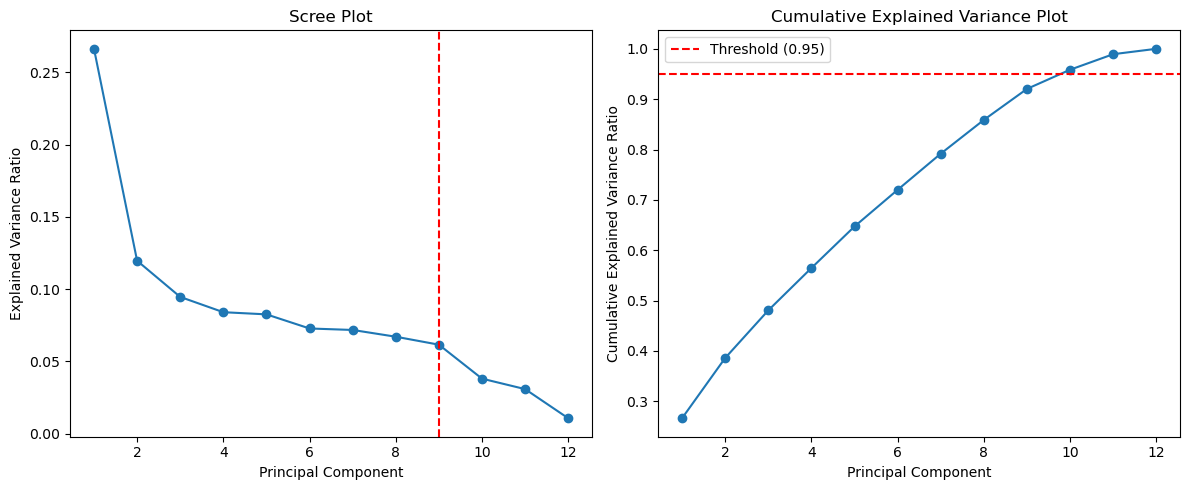

Optimal number of components: 9, threshold: 0.95


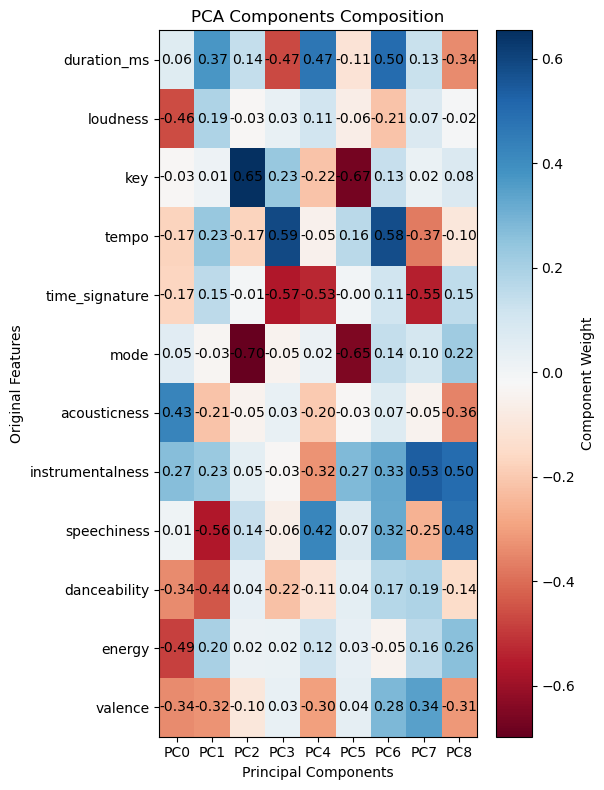

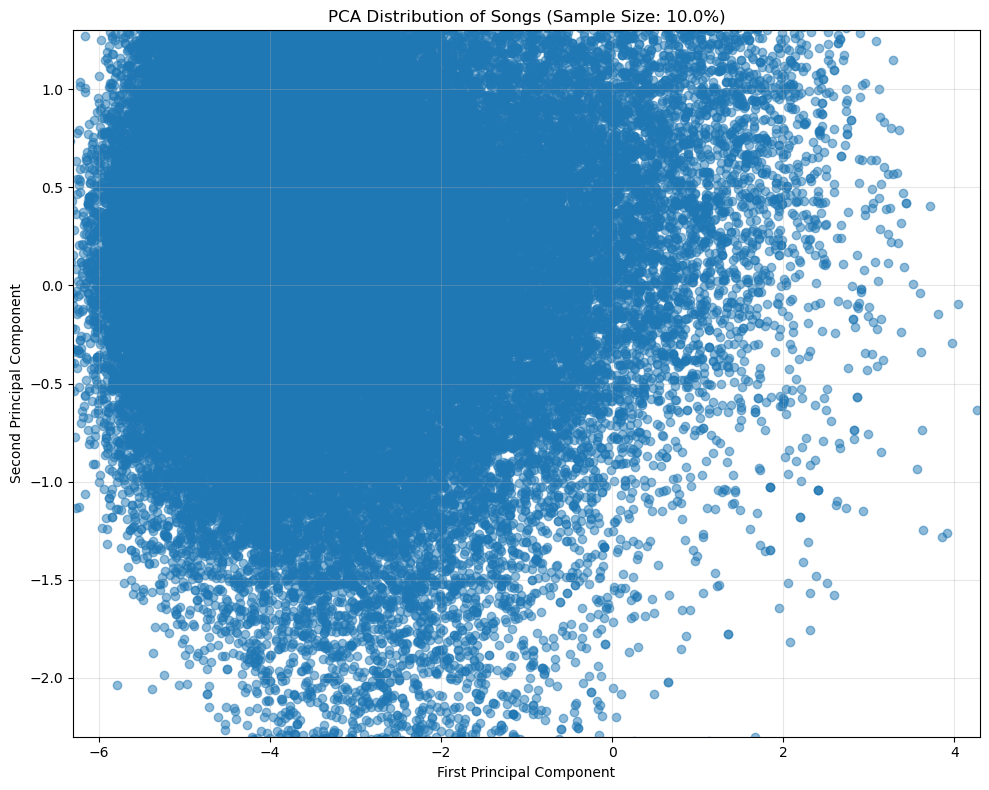

Silhouette score for k=2: 0.36419212795988687


Silhouette score for k=3: 0.3968352192912956


Silhouette score for k=4: 0.2821575639198592


Silhouette score for k=5: 0.40333162093339503


Silhouette score for k=6: 0.30992475081778825


Silhouette score for k=7: 0.2875283488281675


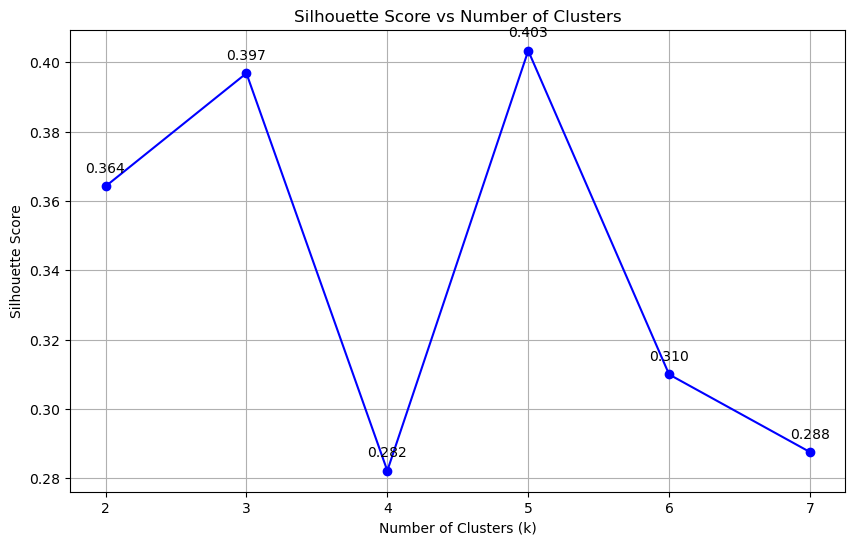


Optimal number of clusters (k) = 5
Best silhouette score = 0.40333162093339503


In [ ]:
#%% run PCA+sample+KMeans

# 1. PCA: find optimal number of components
optimal_n, features_pca, explained_variances, cumulative_variance, model_pca = find_optimal_pca_components(features)
features_pca.persist()
# PCA composition
components_df = analyze_pca_composition(model_pca, feature_cols)
# PCA sample
plot_pca_sample(features_pca, sample_size=0.1)
# PCA yearly distribution animation
#plot_yearly_distribution_animation(features_pca, df, sample_size=0.1)
# 2. KMeans: find optimal k, based on PCA-transformed features
optimal_k_pca, kmeans_predictions_pca, silhouettes_pca = find_optimal_kmeans(features_pca,k_values=range(2, 8))

In [ ]:
#%% merge cluster results

# merge to get cluster results
merged_results = kmeans_predictions_pca.withColumn("tmp_id", F.monotonically_increasing_id()) \
            .join(df_features.withColumn("tmp_id", F.monotonically_increasing_id()).withColumnRenamed("features", "raw_features"), on="tmp_id", how="inner").drop("tmp_id") \
            .join(df,on=["id","name","artist"],how="inner")
merged_results.show()
merged_results.count()

# Get cluster counts
cluster_counts = merged_results.groupby('prediction').count()
cluster_counts.show()

# Filter out clusters with less than 100000 songs
small_clusters = cluster_counts.filter(F.col("count") < 10000).select("prediction").rdd.flatMap(lambda x: x).collect()
cluster_results = merged_results.filter(~F.col("prediction").isin(small_clusters))

# filter out songs before 1920 and after 2020
cluster_results = cluster_results.filter(F.year(F.to_timestamp('release_date')).between(1920, 2020))

# old cluster distribution
cluster_results.groupby('prediction') \
              .count() \
              .orderBy('prediction') \
              .show()
'''

from pyspark.sql import Window
from pyspark.sql import functions as F

# get distinct cluster IDs and sort
distinct_clusters = cluster_results.select("prediction").distinct().orderBy("prediction")

# create new cluster IDs
window_spec = Window.orderBy("prediction")
renumbered_clusters = distinct_clusters.withColumn("new_prediction", F.row_number().over(window_spec) - 1)

# map back to original data
cluster_results = cluster_results.join(
    renumbered_clusters, on="prediction", how="left"
).drop("prediction").withColumnRenamed("new_prediction", "prediction")

cluster_results.groupby('prediction') \
              .count() \
              .orderBy('prediction') \
              .show()
'''

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+-----------+--------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|                  id|                name|              artist|            features|prediction|        raw_features|popularity|duration_ms|explicit|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+-----------+--------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|000KblXP5csWFFFsD...|              Podrás|       Tamara Castro|[-3.0024666237486...|         0|[240013.0, -5.0, ...|        35|     240013|   false|  

+----------+------+
|prediction| count|
+----------+------+
|         1|237197|
|         3| 32430|
|         4|  3759|
|         2|  9590|
|         0|448995|
+----------+------+



ERROR:root:KeyboardInterrupt while sending command.>                (0 + 0) / 1]
Traceback (most recent call last):
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#%% merge cluster results

# merge to get cluster results
merged_results = kmeans_predictions_pca.withColumn("tmp_id", F.monotonically_increasing_id()) \
            .join(df_features.withColumn("tmp_id", F.monotonically_increasing_id()).withColumnRenamed("features", "raw_features"), on="tmp_id", how="inner").drop("tmp_id") \
            .join(df,on=["id","name","artist"],how="inner")
merged_results.show()
merged_results.count()

# Get cluster counts
cluster_counts = merged_results.groupby('prediction').count()
cluster_counts.show()

# Filter out clusters with less than 100000 songs
#small_clusters = cluster_counts.filter(F.col("count") < 10000).select("prediction").rdd.flatMap(lambda x: x).collect()
#cluster_results = merged_results.filter(~F.col("prediction").isin(small_clusters))

# filter out songs before 1920 and after 2020
cluster_results = cluster_results.filter(F.year(F.to_timestamp('release_date')).between(1920, 2020))

# old cluster distribution
cluster_results.groupby('prediction') \
              .count() \
              .orderBy('prediction') \
              .show()
'''

from pyspark.sql import Window
from pyspark.sql import functions as F

# get distinct cluster IDs and sort
distinct_clusters = cluster_results.select("prediction").distinct().orderBy("prediction")

# create new cluster IDs
window_spec = Window.orderBy("prediction")
renumbered_clusters = distinct_clusters.withColumn("new_prediction", F.row_number().over(window_spec) - 1)

# map back to original data
cluster_results = cluster_results.join(
    renumbered_clusters, on="prediction", how="left"
).drop("prediction").withColumnRenamed("new_prediction", "prediction")

cluster_results.groupby('prediction') \
              .count() \
              .orderBy('prediction') \
              .show()
'''

ERROR:root:KeyboardInterrupt while sending command.>                (0 + 0) / 1]
Traceback (most recent call last):
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#%% merge cluster results

# merge to get cluster results
merged_results = kmeans_predictions_pca.withColumn("tmp_id", F.monotonically_increasing_id()) \
            .join(df_features.withColumn("tmp_id", F.monotonically_increasing_id()).withColumnRenamed("features", "raw_features"), on="tmp_id", how="inner").drop("tmp_id") \
            .join(df,on=["id","name","artist"],how="inner")
merged_results.show()
merged_results.count()

# Get cluster counts
cluster_counts = merged_results.groupby('prediction').count()
cluster_counts.show()

# Filter out clusters with less than 100000 songs
#small_clusters = cluster_counts.filter(F.col("count") < 10000).select("prediction").rdd.flatMap(lambda x: x).collect()
#cluster_results = merged_results.filter(~F.col("prediction").isin(small_clusters))
cluster_results = merged_results

# filter out songs before 1920 and after 2020
cluster_results = cluster_results.filter(F.year(F.to_timestamp('release_date')).between(1920, 2020))

# old cluster distribution
cluster_results.groupby('prediction') \
              .count() \
              .orderBy('prediction') \
              .show()
'''

from pyspark.sql import Window
from pyspark.sql import functions as F

# get distinct cluster IDs and sort
distinct_clusters = cluster_results.select("prediction").distinct().orderBy("prediction")

# create new cluster IDs
window_spec = Window.orderBy("prediction")
renumbered_clusters = distinct_clusters.withColumn("new_prediction", F.row_number().over(window_spec) - 1)

# map back to original data
cluster_results = cluster_results.join(
    renumbered_clusters, on="prediction", how="left"
).drop("prediction").withColumnRenamed("new_prediction", "prediction")

cluster_results.groupby('prediction') \
              .count() \
              .orderBy('prediction') \
              .show()
'''

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+-----------+--------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|                  id|                name|              artist|            features|prediction|        raw_features|popularity|duration_ms|explicit|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+-----------+--------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|000KblXP5csWFFFsD...|              Podrás|       Tamara Castro|[-3.0024666237486...|         0|[240013.0, -5.0, ...|        35|     240013|   false|  

+----------+------+
|prediction| count|
+----------+------+
|         1|237197|
|         3| 32430|
|         4|  3759|
|         2|  9590|
|         0|448995|
+----------+------+



+----------+------+
|prediction| count|
+----------+------+
|         0|448995|
|         1|237197|
|         2|  9590|
|         3| 32430|
|         4|  3759|
+----------+------+



'\n\nfrom pyspark.sql import Window\nfrom pyspark.sql import functions as F\n\n# get distinct cluster IDs and sort\ndistinct_clusters = cluster_results.select("prediction").distinct().orderBy("prediction")\n\n# create new cluster IDs\nwindow_spec = Window.orderBy("prediction")\nrenumbered_clusters = distinct_clusters.withColumn("new_prediction", F.row_number().over(window_spec) - 1)\n\n# map back to original data\ncluster_results = cluster_results.join(\n    renumbered_clusters, on="prediction", how="left"\n).drop("prediction").withColumnRenamed("new_prediction", "prediction")\n\ncluster_results.groupby(\'prediction\')               .count()               .orderBy(\'prediction\')               .show()\n'

In [ ]:
#%%

plot_cluster_scatter(cluster_results)

# Show top 10 songs from each cluster
for cluster_id in range(cluster_results.select('prediction').distinct().count()):
    print(f"\nTop 10 songs in Cluster {cluster_id}:")
    cluster_results.filter(F.col('prediction') == cluster_id) \
                  .select('name', 'artist', 'release_date') \
                  .show(10, truncate=False)

NameError: name 'plot_cluster_scatter' is not defined

In [ ]:
#%% visualization functions

def exact_to_pd(cluster_full_data,artist_name=None,sample_size=0.1,seed=None):
    '''extract a subset of data, for visualization'''
    num_clusters = cluster_full_data.select('prediction').distinct().count()
    colors = plt.cm.Dark2(np.linspace(0, 1, num_clusters))
    if artist_name is None:
        if seed is None:
            cluster_data = cluster_full_data.sample(False, sample_size)  
        else:
            cluster_data = cluster_full_data.sample(False, sample_size, seed=seed)  
    else:
        cluster_data = cluster_full_data.filter(F.col("artist") == artist_name)
    cluster_data = cluster_data.toPandas()
    cluster_data['year'] = pd.to_datetime(cluster_data['release_date']).dt.year
    return num_clusters,colors,cluster_data

def plot_cluster_distribution(cluster_data,artist_name=None,sample_size=0.1,seed=None):
    """Plot distribution of songs across clusters"""
    num_clusters,colors,cluster_data=exact_to_pd(cluster_data,artist_name,sample_size,seed)
 
    all_clusters = pd.Series(0, index=range(num_clusters))
    cluster_counts = cluster_data['prediction'].value_counts()
    cluster_counts = cluster_counts.combine_first(all_clusters)
    cluster_counts = cluster_counts.sort_index()
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cluster_counts.index, cluster_counts.values)
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
        
    plt.xlabel('Cluster')
    plt.ylabel('Number of Songs')
    plt.title(f'Distribution of Songs Across Clusters')
    plt.show()
    
    return cluster_counts

def plot_cluster_evolution(cluster_data, artist_name=None, sample_size=0.1, seed=None):
    """Plot evolution of clusters over time"""
    num_clusters, colors, cluster_data = exact_to_pd(cluster_data, artist_name, sample_size, seed)
    
    # Calculate proportion of each cluster per year
    yearly_proportions = cluster_data.pivot_table(
        index='year',
        columns='prediction',
        aggfunc='size',
        fill_value=0
    )
    yearly_proportions = yearly_proportions.div(yearly_proportions.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each cluster separately to ensure correct color mapping
    bottom = np.zeros(len(yearly_proportions))
    for cluster in range(num_clusters):
        if cluster in yearly_proportions.columns:
            values = yearly_proportions[cluster].values
            ax.fill_between(yearly_proportions.index, bottom, bottom + values, 
                          alpha=0.7, label=f'Cluster {cluster}',
                          color=colors[cluster])
            bottom += values
    
    plt.xlabel('Year')
    plt.ylabel('Proportion of Songs')
    plt.title('Evolution of Song Clusters Over Time')
    plt.legend()
    plt.show()

def plot_cluster_scatter(cluster_data, artist_name=None, dim_1=0, dim_2=1,sample_size=0.1,seed=None):
    """Plot scatter of clusters in PCA space"""
    num_clusters, colors,cluster_data=exact_to_pd(cluster_data, artist_name,sample_size,seed)
    markers = ['o', 's', '^', 'v', 'D', 'p', 'h']
    plt.figure(figsize=(10, 8))
    for cluster in range(num_clusters):
        plot_data = cluster_data[cluster_data["prediction"] == cluster]
        plt.scatter(plot_data["features"].apply(lambda x: float(x[dim_1])),
                   plot_data["features"].apply(lambda x: float(x[dim_2])),
                   c=[colors[cluster]], 
                   marker=markers[cluster % len(markers)],
                   label=f'Cluster {cluster}',
                   s=100)
        for _, row in plot_data.iterrows():
            plt.annotate(row["name"], 
                        (float(row["features"][dim_1]), float(row["features"][dim_2])),
                    xytext=(5, 5),
                        textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                        fontsize=8)
    plt.xlabel(f"Component {dim_1}")
    plt.ylabel(f"Component {dim_2}")
    plt.title("Songs Clustered in Dimensionally Reduced Space")
    plt.legend()
    plt.show()

def plot_cluster_radar(cluster_data, artist_name=None,sample_size=0.1,seed=None):
    """
    Create a radar plot to compare cluster centroids with standardized features
    
    Args:
        cluster_data: DataFrame with cluster predictions and features
        artist_name: Optional artist name to filter data
    """
    # Extract data and get number of clusters
    num_clusters, colors, cluster_data = exact_to_pd(cluster_data, artist_name,sample_size,seed)
    
    # Get feature values from the features column
    feature_values = pd.DataFrame(cluster_data['raw_features'].tolist(), 
                                columns=feature_cols)
    
    # Calculate global means and standard deviations for standardization
    global_means = feature_values[feature_cols].mean()
    global_stds = feature_values[feature_cols].std()
    
    # Standardize features
    standardized_values = feature_values.copy()
    for col in feature_cols:
        if global_stds[col] > 0:  # Avoid division by zero
            standardized_values[col] = (feature_values[col] - global_means[col]) / global_stds[col]
        else:
            standardized_values[col] = N
    
    # Add prediction column
    standardized_values['prediction'] = cluster_data['prediction']
    
    # Calculate mean values for each cluster using standardized features
    cluster_means = standardized_values.groupby('prediction')[feature_cols].mean()
    
    # Set up the angles for radar plot
    angles = np.linspace(0, 2*np.pi, len(feature_cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the circle
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot data for each cluster
    for cluster in range(num_clusters):
        if cluster in cluster_means.index:
            values = cluster_means.loc[cluster].values
            values = np.concatenate((values, [values[0]]))  # Close the polygon
            
            ax.plot(angles, values, 'o-', linewidth=2, 
                   label=f'Cluster {cluster}', 
                   color=colors[cluster])
            ax.fill(angles, values, alpha=0.25, color=colors[cluster])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_cols, size=15)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    title = "Cluster Characteristics"
    if artist_name:
        title += f" for {artist_name}"
    plt.title(title, fontsize=17)
    plt.tight_layout()
    plt.show()
    
    return cluster_means

def plot_cluster_scatter(cluster_data, artist_name=None, sample_size=0.1, seed=None):
    """Plot scatter plot of clusters in PCA space with different dimension combinations"""
    num_clusters, colors, cluster_data = exact_to_pd(cluster_data, artist_name, sample_size, seed)
    
    # Extract PCA coordinates
    pca_coords = np.vstack(cluster_data['features'].values)
    
    # Get dimensions to plot
    dims = [(0,1), (0,2), (1,2)]  # Different combinations of first 3 PCs
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Cluster Distribution in PCA Space', fontsize=16)
    
    for ax, (dim1, dim2) in zip(axes, dims):
        # Plot each cluster
        for cluster in range(num_clusters):
            mask = cluster_data['prediction'] == cluster
            ax.scatter(pca_coords[mask, dim1], 
                      pca_coords[mask, dim2],
                      c=[colors[cluster]], 
                      label=f'Cluster {cluster}',
                      alpha=0.6,
                      s=20)
        
        ax.set_xlabel(f'PC{dim1+1}')
        ax.set_ylabel(f'PC{dim2+1}')
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first subplot
        if dim1 == 0 and dim2 == 1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if artist_name:
        plt.suptitle(f'Cluster Distribution in PCA Space - {artist_name}', fontsize=16)
    
    plt.tight_layout()
    plt.show()

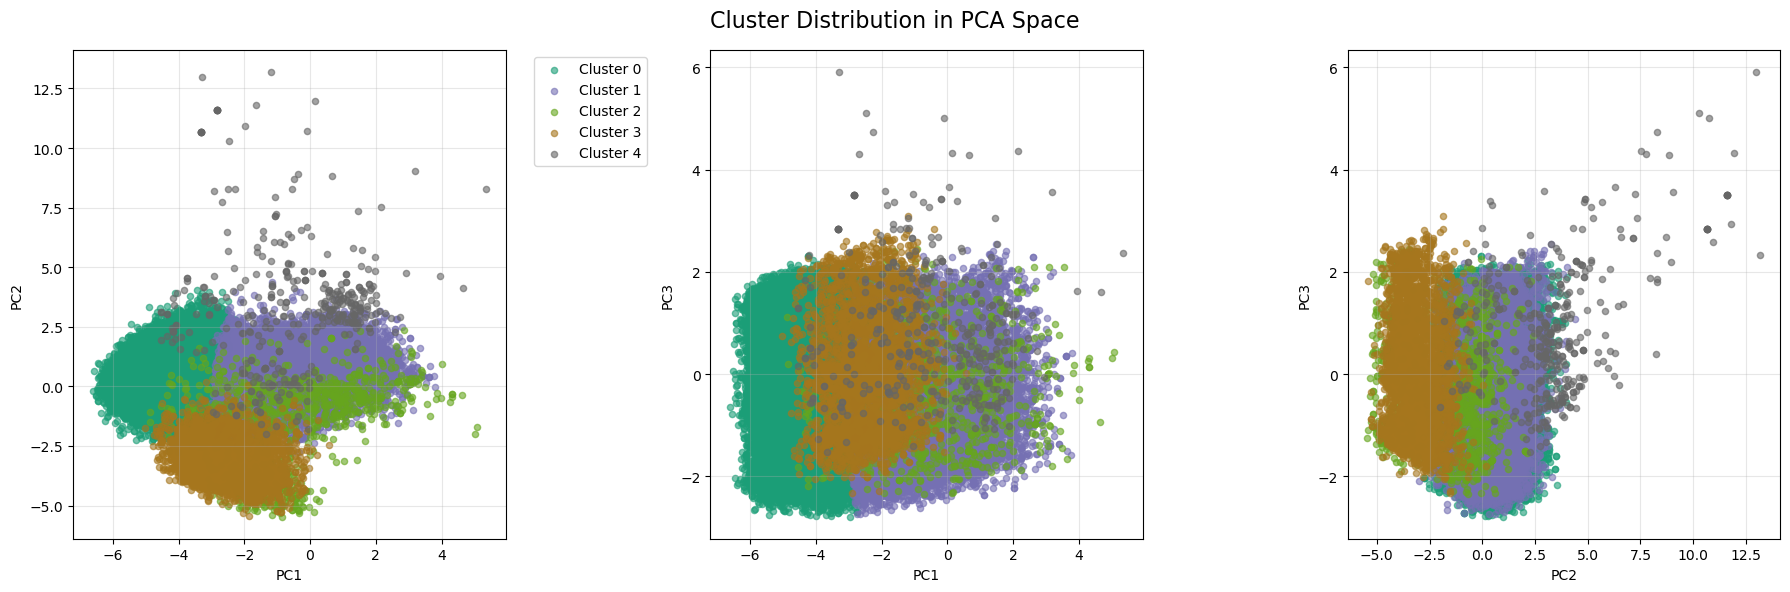


Top 10 songs in Cluster 0:


+----------------------------+--------------+------------+
|name                        |artist        |release_date|
+----------------------------+--------------+------------+
|24.11.94 - Wersja Akustyczna|Golden Life   |2012-01-01  |
|Adam et Ève                 |Kaïn          |2005-05-03  |
|Will Anything Happen        |Blondie       |1978-09-23  |
|Podrás                      |Tamara Castro |2006-07-08  |
|Tenebre                     |Sercho        |2017-12-22  |
|Tenebre                     |Ultimo        |2017-12-22  |
|Me Quieres Perjudicar       |Trio Maravilla|1954-01-01  |
|I Don't Want A Lover        |Texas         |1989-01-01  |
|Eu, Você, O Mar e Ela       |Luan Santana  |2016-11-04  |
|Es un Secreto               |Plan B        |2011-08-23  |
+----------------------------+--------------+------------+
only showing top 10 rows


Top 10 songs in Cluster 1:


+--------------------------------------------------------------------------+---------------------------------+------------+
|name                                                                      |artist                           |release_date|
+--------------------------------------------------------------------------+---------------------------------+------------+
|Mere Hamsafar                                                             |Talat Mahmood                    |1953-12-31  |
|Torpedo Juice                                                             |Meade Lux Lewis                  |1954-01-01  |
|Symphony in B-Flat Major, Op. 20: II. Très lent - Un peu plus vite        |Ernest Chausson                  |1951-01-01  |
|Symphony in B-Flat Major, Op. 20: II. Très lent - Un peu plus vite        |Pierre Monteux                   |1951-01-01  |
|Undrastrákurinn Óli                                                       |Þrjú á palli ásamt Sólskinskórnum|1975-01-01  |
|My Shin

+-----------------------------------------------------------------------------------------------------+-----------------------+------------+
|name                                                                                                 |artist                 |release_date|
+-----------------------------------------------------------------------------------------------------+-----------------------+------------+
|Welcoming the Sabbath - A Friday Evening Service: Borchu (Bless the Lord)                            |Sholom Secunda         |1950-01-01  |
|Turandot / Act 2: Ho una casa nell'Honan                                                             |Pier Francesco Poli    |1973-09-01  |
|Магарешката кожа-част 6                                                                              |Павел Сираков          |1988-02-17  |
|You Better Go Now                                                                                    |Billie Holiday         |1956-01-01  |
|La Cruz del 

+------------------------------------------+--------------------+------------+
|name                                      |artist              |release_date|
+------------------------------------------+--------------------+------------+
|Chapter 173 - The Unlit Lamp              |Radclyffe Hall      |1924-01-01  |
|Chapter 173 - The Unlit Lamp              |Alice White         |1924-01-01  |
|Jag lämnar körsbärsdalen                  |Bröderna Lejonhjärta|1977-01-01  |
|Chapter 1.18 - Król Maciuś Pierwszy       |Janusz Korczak      |1923-12-27  |
|Kalling                                   |Bergeners           |1977-03-01  |
|Na mee vo Steischlag i de Berge           |Globi               |1989-06-08  |
|Мы открываем бизнес (Skit)                |SHOOVAL             |2018-07-05  |
|En morgon vinkade Farmor inte… - Del.1    |Bamse               |2004-05-01  |
|038 - Die weiße Schmuggler-Yacht - Teil 09|TKKG Retro-Archiv   |1985-03-01  |
|Kapitel 16 - Die Hexenschule (Folge 071)  |Bibi Blo

: 

In [ ]:
#%%

plot_cluster_scatter(cluster_results)

# Show top 10 songs from each cluster
for cluster_id in range(cluster_results.select('prediction').distinct().count()):
    print(f"\nTop 10 songs in Cluster {cluster_id}:")
    cluster_results.filter(F.col('prediction') == cluster_id) \
                  .select('name', 'artist', 'release_date') \
                  .show(10, truncate=False)

In [ ]:
# %% Load data and packages

#environment: amd 2nodes 60G 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from prophet import Prophet
from scipy.stats import gaussian_kde


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)

# Note potentially relevant features like danceability, energy, acousticness, etc.
print(df.columns)
print("Number of rows before filtering:", df.count())

feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

24/11/27 13:56:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
['id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist']
Number of rows before filtering: 745785


In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
#df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
#print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
'''
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行
'''
'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 741255


"\n['id',\n 'name',\n 'popularity',\n 'duration_ms',\n 'explicit', #ignore\n 'release_date',\n 'danceability',\n 'energy',\n 'key',\n 'loudness',\n 'mode',\n 'speechiness',\n 'acousticness',\n 'instrumentalness',\n 'liveness',#ignore\n 'valence',\n 'tempo',\n 'time_signature',\n 'artist']\n "

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

root
 |-- features: vector (nullable = true)



In [ ]:
# %% K-means and PCA visualization functions

# try different numbers of clusters to find optimal k
def find_optimal_kmeans(features, k_values=range(3, 5)):
    """
    Find optimal k for KMeans clustering using silhouette scores
    
    Args:
        features: DataFrame with feature vectors
        k_values: Range of k values to try
        
    Returns:
        optimal_k: Optimal number of clusters
        kmeans_predictions: Predictions using optimal k
        silhouettes: List of silhouette scores for each k
    """
    silhouettes = []
    
    for k in k_values:
        # train model
        kmeans = KMeans(k=k, seed=1)
        model = kmeans.fit(features)
        
        # make predictions
        predictions = model.transform(features)
        
        # evaluate clustering
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
        print(f"Silhouette score for k={k}: {silhouette}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouettes, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    
    # Add value labels on the points
    for k, silhouette in zip(k_values, silhouettes):
        plt.annotate(f'{silhouette:.3f}', 
                    (k, silhouette), 
                    textcoords="offset points", 
                    xytext=(0,10),
                    ha='center')
    
    plt.show()

    # find optimal k
    optimal_k = k_values[silhouettes.index(max(silhouettes))]
    print(f"\nOptimal number of clusters (k) = {optimal_k}")
    print(f"Best silhouette score = {max(silhouettes)}")
    
    # train final model with optimal k
    kmeans = KMeans(k=optimal_k, seed=1)
    kmeans_model = kmeans.fit(features)
    optimal_predictions = kmeans_model.transform(features)
    
    return optimal_k, optimal_predictions, silhouettes

def analyze_pca_composition(model_pca, feature_cols):
    """
    Analyze and visualize the composition of a trained PCA model using heatmap
    
    Args:
        model_pca: Trained PCA model
        feature_cols: List of original feature names
    """
    # Get principal components matrix
    pc_matrix = model_pca.pc.toArray()
    n_components = pc_matrix.shape[1]
    
    # Create DataFrame with component compositions
    components_df = pd.DataFrame(
        pc_matrix,
        columns=[f'PC{i}' for i in range(n_components)],
        index=feature_cols
    )
    
    # Plot heatmap
    plt.figure(figsize=(6, 8))
    im = plt.imshow(components_df, cmap='RdBu', aspect='auto')
    plt.colorbar(im, label='Component Weight')
    
    # Add value annotations
    for i in range(len(feature_cols)):
        for j in range(n_components):
            plt.text(j, i, f'{components_df.iloc[i, j]:.2f}',
                    ha='center', va='center')
    
    # Customize plot
    plt.xticks(range(n_components), components_df.columns)
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title('PCA Components Composition')
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    
    plt.tight_layout()
    plt.show()
    
    return components_df

def find_optimal_pca_components(features,threshold=0.95,k=None):
    """
    Find optimal number of PCA components by analyzing explained variance
    
    Args:
        features: DataFrame with feature vectors
        feature_cols: List of feature column names
        
    Returns:
        explained_variances: Array of explained variance ratios
        cumulative_variance: Array of cumulative explained variance ratios
    """
    n_features = features.first()["features"].size
    pca = PCA(k=n_features, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    explained_variances = model.explainedVariance
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]

    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")

    # Find optimal number of components
    if k is None:
        optimal_n = next((i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold), len(cumulative_variance))
    else:
        optimal_n = k

    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal number of components ({optimal_n})')

    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    # Add threshold line at 0.8
    if k is None:
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')

    plt.tight_layout()
    plt.show()

    if k is None:
        print(f"Optimal number of components: {optimal_n}, threshold: {threshold}")
    else:
        print(f"Optimal number of components: {optimal_n}")

    # transform features according to optimal number of components
    pca = PCA(k=optimal_n, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    pca_results = model.transform(features) \
                        .select('pcaFeatures')
    
    pca_features = pca_results.rdd.map(lambda row: Vectors.dense(row.pcaFeatures))
    pca_features = spark.createDataFrame(pca_features.map(Row), ["features"])

    return optimal_n, pca_features, explained_variances, cumulative_variance, model

# sample PCA points
def plot_pca_sample(features_pca, sample_size=0.1, seed=None):
    """
    Plot sampled PCA points in 2D space
    
    Args:
        features_pca: DataFrame with PCA features
        sample_size: Fraction of data to sample (default 0.1)
        seed: Random seed for sampling (optional)
    """
    # Sample data
    if seed is None:
        sampled_data = features_pca.sample(False, sample_size)
    else:
        sampled_data = features_pca.sample(False, sample_size, seed=seed)
    
    # Convert to pandas and extract coordinates
    df = sampled_data.toPandas()
    coords = np.vstack(df['features'].values)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'PCA Distribution of Songs (Sample Size: {sample_size*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.ylim(-2.3, 1.3)
    plt.xlim(-6.3, 4.3)
    plt.tight_layout()
    plt.show()


def plot_yearly_distribution_animation(features_pca, df, sample_size=0.1, grid_size=100, seed=42):
    """
    Create an animated plot showing the evolution of song distribution in PCA space over time
    
    Args:
        features_pca: DataFrame with PCA features
        df: Original dataframe with metadata
        sample_size: Fraction of data to sample
        grid_size: Number of grid cells in each dimension
        seed: Random seed for sampling
    """
    # Sample data
    sampled_pca = features_pca.sample(False, sample_size, seed=seed)
    sampled_df = df.sample(False, sample_size, seed=seed)
    
    # Convert to pandas
    pca_df = sampled_pca.toPandas()
    metadata_df = sampled_df.select('release_date').toPandas()
    
    # Extract PCA coordinates and years
    pca_coords = np.vstack(pca_df['features'].values)
    years = pd.to_datetime(metadata_df['release_date']).dt.year.values
    
    # Create grid for density estimation
    x_edges = np.linspace(pca_coords[:,0].min(), pca_coords[:,0].max(), grid_size)
    y_edges = np.linspace(pca_coords[:,1].min(), pca_coords[:,1].max(), grid_size)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create colorbar axes
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    
    def update(frame):
        ax.clear()
        year = sorted(np.unique(years))[frame]
        year_mask = years == year
        year_coords = pca_coords[year_mask]
        
        if len(year_coords) > 0:
            # Calculate 2D histogram
            hist, _, _ = np.histogram2d(
                year_coords[:,0], 
                year_coords[:,1],
                bins=[x_edges, y_edges]
            )
            
            # Plot heatmap
            im = ax.imshow(
                hist.T,
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                origin='lower',
                cmap='viridis',
                aspect='auto'
            )
            
            ax.set_title(f'Year: {year}')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            
            # Update colorbar
            if frame == 0:
                cbar = fig.colorbar(im, cax=cbar_ax, label='Number of Songs')
                cbar.ax.yaxis.label.set_color('white')
                cbar.ax.tick_params(colors='white')
    
    # Create animation
    unique_years = sorted(np.unique(years))
    anim = animation.FuncAnimation(
        fig, 
        update,
        frames=len(unique_years),
        interval=100,  # 100ms between frames
        repeat=True
    )
    
    plt.suptitle('Evolution of Music Distribution in PCA Space', y=1.02, fontsize=16)
    plt.tight_layout()
    
    # Save animation
    anim.save('music_distribution_evolution.gif', writer='pillow')
    plt.show()

24/11/27 13:56:43 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/11/27 13:56:43 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Component 1 explained variance: 0.2665
Cumulative explained variance: 0.2665
Component 2 explained variance: 0.1193
Cumulative explained variance: 0.3858
Component 3 explained variance: 0.0947
Cumulative explained variance: 0.4805
Component 4 explained variance: 0.0840
Cumulative explained variance: 0.5645
Component 5 explained variance: 0.0825
Cumulative explained variance: 0.6470
Component 6 explained variance: 0.0728
Cumulative explained variance: 0.7197
Component 7 explained variance: 0.0718
Cumulative explained variance: 0.7915
Component 8 explained variance: 0.0671
Cumulative explained variance: 0.8586
Component 9 explained variance: 0.0616
Cumulative explained variance: 0.9202
Component 10 explained variance: 0.0382
Cumulative explained variance: 0.9584
Component 

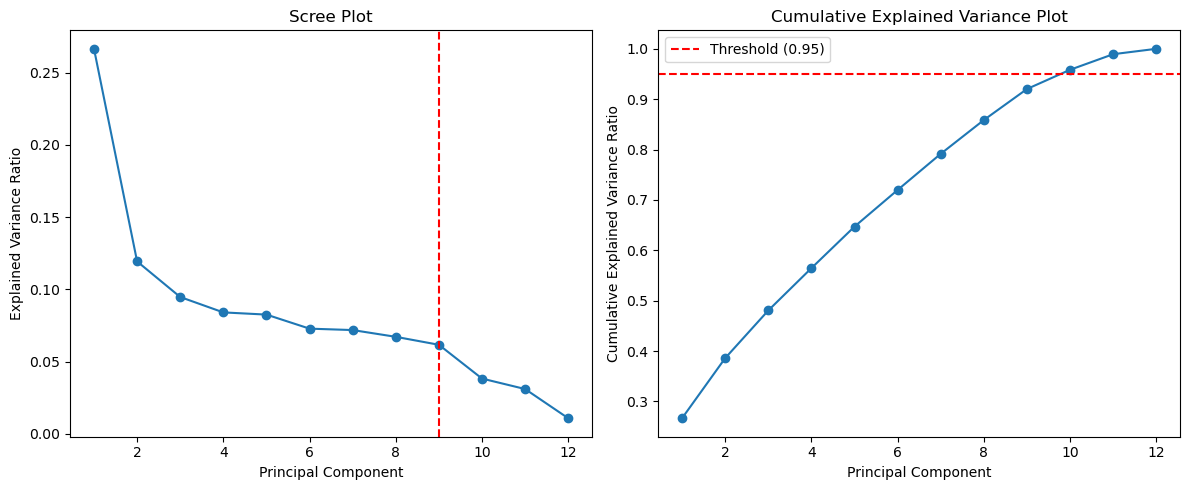

Optimal number of components: 9, threshold: 0.95


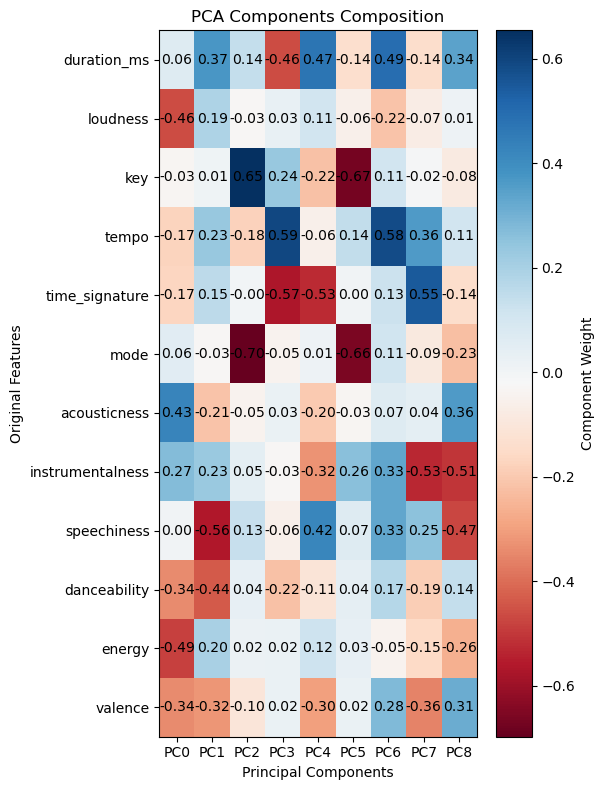

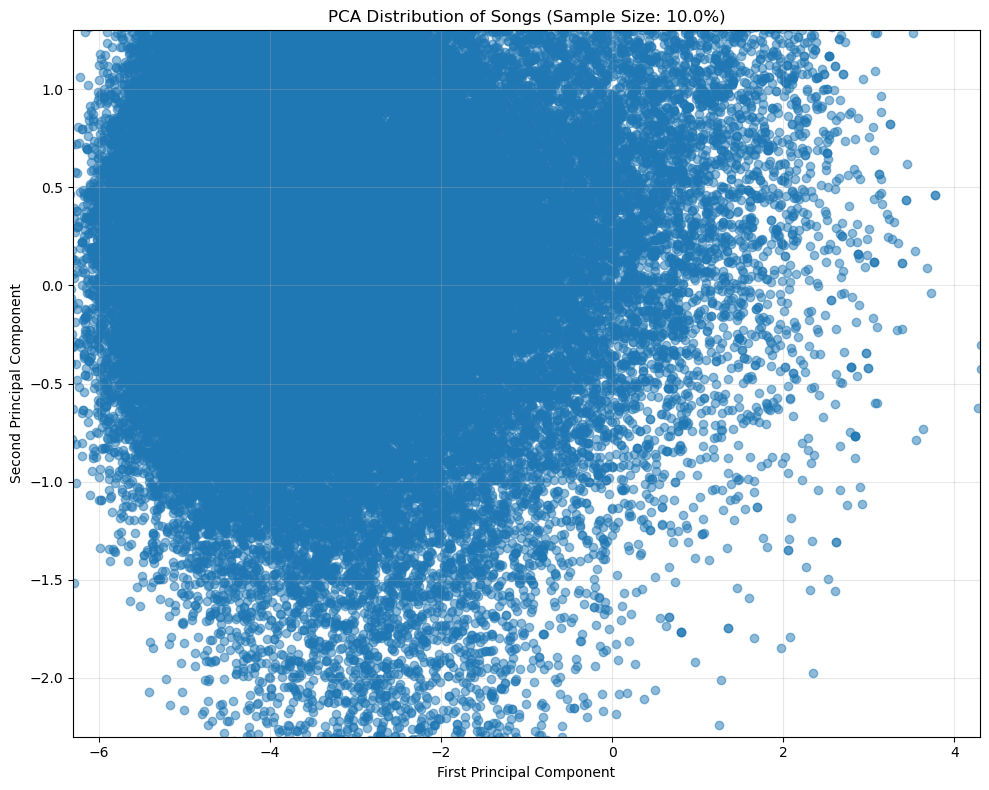

Silhouette score for k=2: 0.3660599818133227
Silhouette score for k=3: 0.21880126143159562


Silhouette score for k=4: 0.18171659458405334


Silhouette score for k=5: 0.17342370259205458


Silhouette score for k=6: 0.20688336039920643


Silhouette score for k=7: 0.23059652367161418


Silhouette score for k=8: 0.2494212538784549


Silhouette score for k=9: 0.25803350980505146


Silhouette score for k=10: 0.25365170167173695


Silhouette score for k=11: 0.20886584652030413


Silhouette score for k=12: 0.24883906152092605


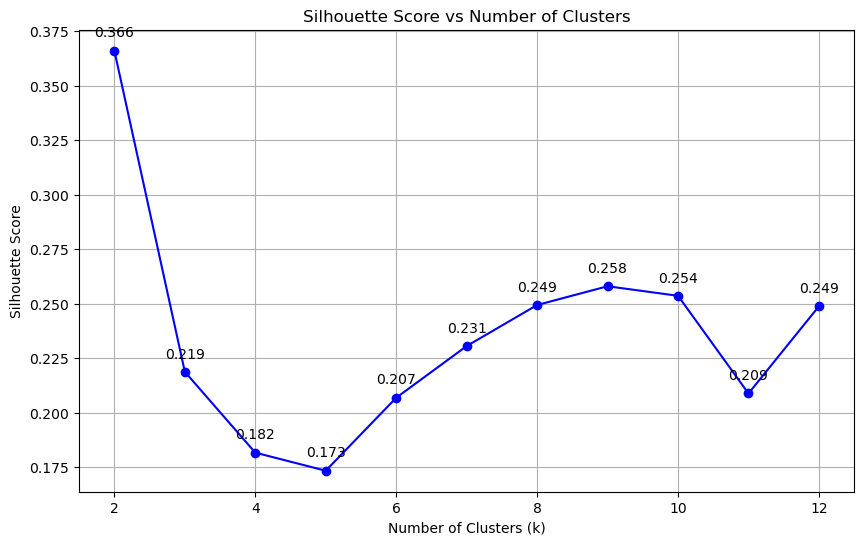


Optimal number of clusters (k) = 2
Best silhouette score = 0.3660599818133227


In [ ]:
#%% run PCA+sample+KMeans

# 1. PCA: find optimal number of components
optimal_n, features_pca, explained_variances, cumulative_variance, model_pca = find_optimal_pca_components(features)
features_pca.persist()
# PCA composition
components_df = analyze_pca_composition(model_pca, feature_cols)
# PCA sample
plot_pca_sample(features_pca, sample_size=0.1)
# PCA yearly distribution animation
#plot_yearly_distribution_animation(features_pca, df, sample_size=0.1)
# 2. KMeans: find optimal k, based on PCA-transformed features
optimal_k_pca, kmeans_predictions_pca, silhouettes_pca = find_optimal_kmeans(features_pca,k_values=range(2, 13))

In [ ]:
# %% Load data and packages

#environment: amd 2nodes 60G 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import DoubleType, ArrayType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
from prophet import Prophet
from scipy.stats import gaussian_kde


spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/home/mikezhu/music/data/spotify_dataset.csv', header=True)

# Note potentially relevant features like danceability, energy, acousticness, etc.
print(df.columns)
print("Number of rows before filtering:", df.count())

feature_cols = [
    #'explicit',
    #'liveness',
    'duration_ms',
    'loudness',
    'key',
    'tempo', 
    'time_signature',
    'mode',
    'acousticness', 
    'instrumentalness',  
    'speechiness',
    'danceability', 
    'energy',
    'valence'
    ]

['id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'artist']
Number of rows before filtering: 745785


In [ ]:
#%% remove null and constrain time horizon

# Remove null values from original dataframe
df = df.dropna()
print("Number of rows after removing nulls:", df.count())
# 仅仅要release_date在1921-2020的
df = df.filter((F.col("release_date").between("1921-01-01", "2020-12-31")))
print("Number of rows within 1921-2020:", df.count())
# 排除在remove_id中的行
'''
# Read remove_id list in a distributed way
remove_id_df = spark.read.csv('/home/mikezhu/remove_id.csv', header=True)
# 假设 remove_list 是要剔除的列表
remove_list = remove_id_df.select('id').rdd.flatMap(lambda x: x).collect()
remove_ids = spark.sparkContext.broadcast(set(remove_list))  # 广播变量

# 过滤 df 中的行
df = df.filter(~F.col("id").isin(remove_ids.value))  # 剔除匹配 id 的行
'''
'''
['id',
 'name',
 'popularity',
 'duration_ms',
 'explicit', #ignore
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',#ignore
 'valence',
 'tempo',
 'time_signature',
 'artist']
 '''

Number of rows after removing nulls: 741255
Number of rows within 1921-2020: 731971


"\n['id',\n 'name',\n 'popularity',\n 'duration_ms',\n 'explicit', #ignore\n 'release_date',\n 'danceability',\n 'energy',\n 'key',\n 'loudness',\n 'mode',\n 'speechiness',\n 'acousticness',\n 'instrumentalness',\n 'liveness',#ignore\n 'valence',\n 'tempo',\n 'time_signature',\n 'artist']\n "

In [ ]:
# %% Data preprocessing

# identify potentially relevant features and add to a feature dataframe

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'id','name', 'artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id','name', 'artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

root
 |-- features: vector (nullable = true)



In [ ]:
# %% K-means and PCA visualization functions

# try different numbers of clusters to find optimal k
def find_optimal_kmeans(features, k_values=range(3, 5)):
    """
    Find optimal k for KMeans clustering using silhouette scores
    
    Args:
        features: DataFrame with feature vectors
        k_values: Range of k values to try
        
    Returns:
        optimal_k: Optimal number of clusters
        kmeans_predictions: Predictions using optimal k
        silhouettes: List of silhouette scores for each k
    """
    silhouettes = []
    
    for k in k_values:
        # train model
        kmeans = KMeans(k=k, seed=1)
        model = kmeans.fit(features)
        
        # make predictions
        predictions = model.transform(features)
        
        # evaluate clustering
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
        print(f"Silhouette score for k={k}: {silhouette}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouettes, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    
    # Add value labels on the points
    for k, silhouette in zip(k_values, silhouettes):
        plt.annotate(f'{silhouette:.3f}', 
                    (k, silhouette), 
                    textcoords="offset points", 
                    xytext=(0,10),
                    ha='center')
    
    plt.show()

    # find optimal k
    optimal_k = k_values[silhouettes.index(max(silhouettes))]
    print(f"\nOptimal number of clusters (k) = {optimal_k}")
    print(f"Best silhouette score = {max(silhouettes)}")
    
    # train final model with optimal k
    kmeans = KMeans(k=optimal_k, seed=1)
    kmeans_model = kmeans.fit(features)
    optimal_predictions = kmeans_model.transform(features)
    
    return optimal_k, optimal_predictions, silhouettes

def analyze_pca_composition(model_pca, feature_cols):
    """
    Analyze and visualize the composition of a trained PCA model using heatmap
    
    Args:
        model_pca: Trained PCA model
        feature_cols: List of original feature names
    """
    # Get principal components matrix
    pc_matrix = model_pca.pc.toArray()
    n_components = pc_matrix.shape[1]
    
    # Create DataFrame with component compositions
    components_df = pd.DataFrame(
        pc_matrix,
        columns=[f'PC{i}' for i in range(n_components)],
        index=feature_cols
    )
    
    # Plot heatmap
    plt.figure(figsize=(6, 8))
    im = plt.imshow(components_df, cmap='RdBu', aspect='auto')
    plt.colorbar(im, label='Component Weight')
    
    # Add value annotations
    for i in range(len(feature_cols)):
        for j in range(n_components):
            plt.text(j, i, f'{components_df.iloc[i, j]:.2f}',
                    ha='center', va='center')
    
    # Customize plot
    plt.xticks(range(n_components), components_df.columns)
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title('PCA Components Composition')
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    
    plt.tight_layout()
    plt.show()
    
    return components_df

def find_optimal_pca_components(features,threshold=0.95,k=None):
    """
    Find optimal number of PCA components by analyzing explained variance
    
    Args:
        features: DataFrame with feature vectors
        feature_cols: List of feature column names
        
    Returns:
        explained_variances: Array of explained variance ratios
        cumulative_variance: Array of cumulative explained variance ratios
    """
    n_features = features.first()["features"].size
    pca = PCA(k=n_features, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    explained_variances = model.explainedVariance
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]

    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")

    # Find optimal number of components
    if k is None:
        optimal_n = next((i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold), len(cumulative_variance))
    else:
        optimal_n = k

    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal number of components ({optimal_n})')

    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    # Add threshold line at 0.8
    if k is None:
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')

    plt.tight_layout()
    plt.show()

    if k is None:
        print(f"Optimal number of components: {optimal_n}, threshold: {threshold}")
    else:
        print(f"Optimal number of components: {optimal_n}")

    # transform features according to optimal number of components
    pca = PCA(k=optimal_n, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    pca_results = model.transform(features) \
                        .select('pcaFeatures')
    
    pca_features = pca_results.rdd.map(lambda row: Vectors.dense(row.pcaFeatures))
    pca_features = spark.createDataFrame(pca_features.map(Row), ["features"])

    return optimal_n, pca_features, explained_variances, cumulative_variance, model

# sample PCA points
def plot_pca_sample(features_pca, sample_size=0.1, seed=None):
    """
    Plot sampled PCA points in 2D space
    
    Args:
        features_pca: DataFrame with PCA features
        sample_size: Fraction of data to sample (default 0.1)
        seed: Random seed for sampling (optional)
    """
    # Sample data
    if seed is None:
        sampled_data = features_pca.sample(False, sample_size)
    else:
        sampled_data = features_pca.sample(False, sample_size, seed=seed)
    
    # Convert to pandas and extract coordinates
    df = sampled_data.toPandas()
    coords = np.vstack(df['features'].values)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'PCA Distribution of Songs (Sample Size: {sample_size*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.ylim(-2.3, 1.3)
    plt.xlim(-6.3, 4.3)
    plt.tight_layout()
    plt.show()


def plot_yearly_distribution_animation(features_pca, df, sample_size=0.1, grid_size=100, seed=42):
    """
    Create an animated plot showing the evolution of song distribution in PCA space over time
    
    Args:
        features_pca: DataFrame with PCA features
        df: Original dataframe with metadata
        sample_size: Fraction of data to sample
        grid_size: Number of grid cells in each dimension
        seed: Random seed for sampling
    """
    # Sample data
    sampled_pca = features_pca.sample(False, sample_size, seed=seed)
    sampled_df = df.sample(False, sample_size, seed=seed)
    
    # Convert to pandas
    pca_df = sampled_pca.toPandas()
    metadata_df = sampled_df.select('release_date').toPandas()
    
    # Extract PCA coordinates and years
    pca_coords = np.vstack(pca_df['features'].values)
    years = pd.to_datetime(metadata_df['release_date']).dt.year.values
    
    # Create grid for density estimation
    x_edges = np.linspace(pca_coords[:,0].min(), pca_coords[:,0].max(), grid_size)
    y_edges = np.linspace(pca_coords[:,1].min(), pca_coords[:,1].max(), grid_size)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create colorbar axes
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    
    def update(frame):
        ax.clear()
        year = sorted(np.unique(years))[frame]
        year_mask = years == year
        year_coords = pca_coords[year_mask]
        
        if len(year_coords) > 0:
            # Calculate 2D histogram
            hist, _, _ = np.histogram2d(
                year_coords[:,0], 
                year_coords[:,1],
                bins=[x_edges, y_edges]
            )
            
            # Plot heatmap
            im = ax.imshow(
                hist.T,
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                origin='lower',
                cmap='viridis',
                aspect='auto'
            )
            
            ax.set_title(f'Year: {year}')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            
            # Update colorbar
            if frame == 0:
                cbar = fig.colorbar(im, cax=cbar_ax, label='Number of Songs')
                cbar.ax.yaxis.label.set_color('white')
                cbar.ax.tick_params(colors='white')
    
    # Create animation
    unique_years = sorted(np.unique(years))
    anim = animation.FuncAnimation(
        fig, 
        update,
        frames=len(unique_years),
        interval=100,  # 100ms between frames
        repeat=True
    )
    
    plt.suptitle('Evolution of Music Distribution in PCA Space', y=1.02, fontsize=16)
    plt.tight_layout()
    
    # Save animation
    anim.save('music_distribution_evolution.gif', writer='pillow')
    plt.show()

Component 1 explained variance: 0.2662
Cumulative explained variance: 0.2662
Component 2 explained variance: 0.1196
Cumulative explained variance: 0.3859
Component 3 explained variance: 0.0946
Cumulative explained variance: 0.4805
Component 4 explained variance: 0.0841
Cumulative explained variance: 0.5645
Component 5 explained variance: 0.0826
Cumulative explained variance: 0.6471
Component 6 explained variance: 0.0728
Cumulative explained variance: 0.7199
Component 7 explained variance: 0.0718
Cumulative explained variance: 0.7917
Component 8 explained variance: 0.0671
Cumulative explained variance: 0.8588
Component 9 explained variance: 0.0616
Cumulative explained variance: 0.9203
Component 10 explained variance: 0.0381
Cumulative explained variance: 0.9584
Component 11 explained variance: 0.0309
Cumulative explained variance: 0.9893
Component 12 explained variance: 0.0107
Cumulative explained variance: 1.0000


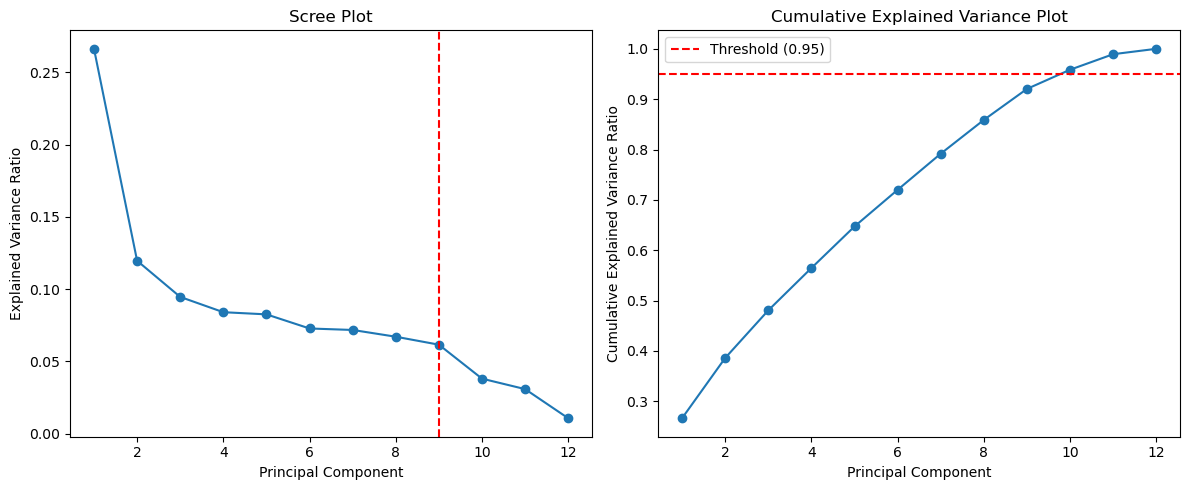

Optimal number of components: 9, threshold: 0.95


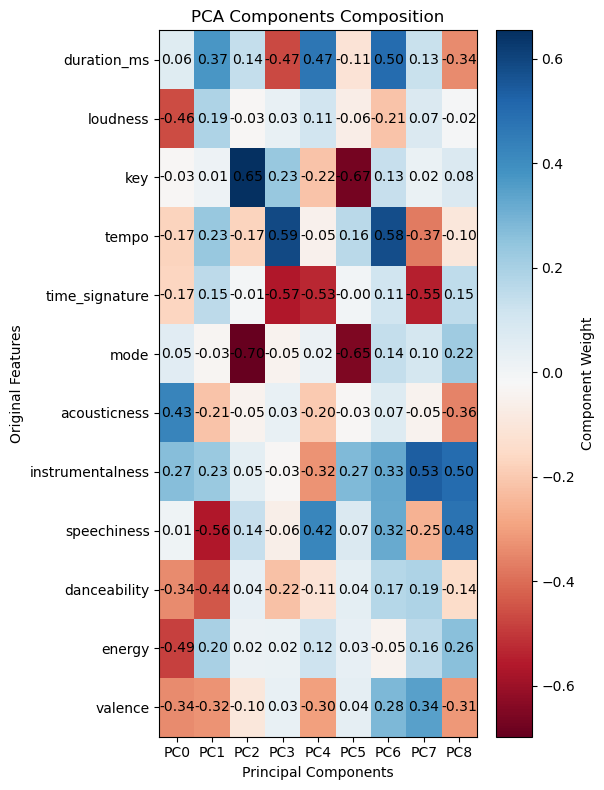

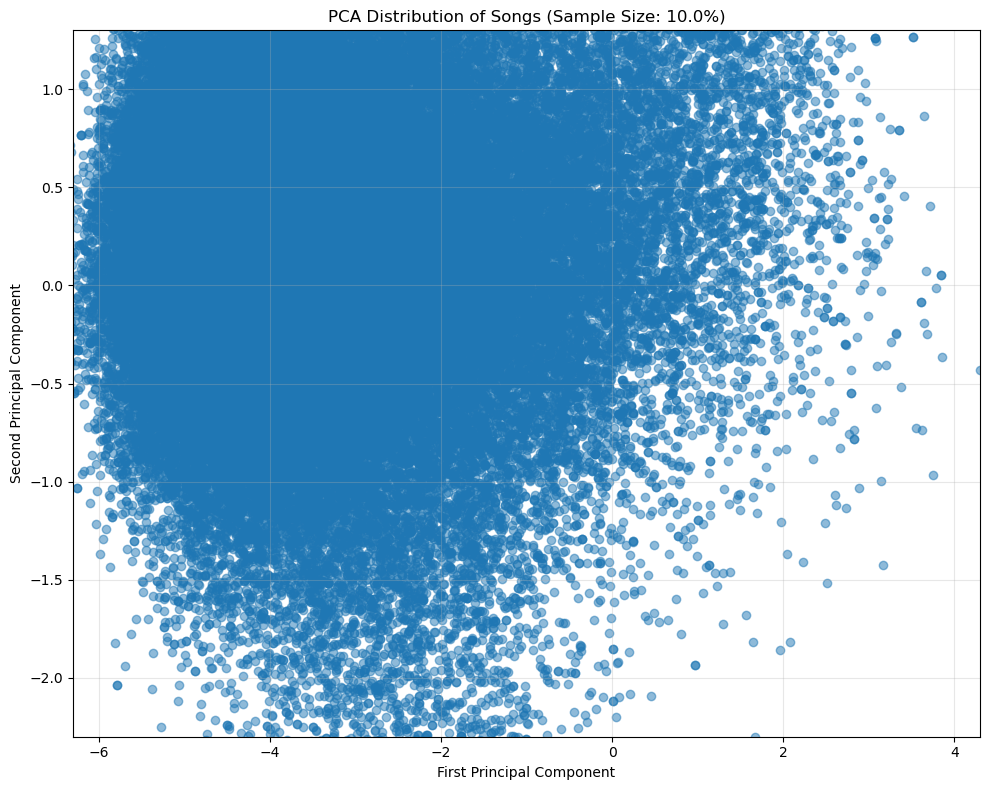

Silhouette score for k=2: 0.36415442529744496


Silhouette score for k=3: 0.396837310312107


Silhouette score for k=4: 0.18559282007808572


Silhouette score for k=5: 0.2778884456760785


Silhouette score for k=6: 0.226662074488022


Silhouette score for k=7: 0.22529108315171698


Silhouette score for k=8: 0.22994898420999343


Silhouette score for k=9: 0.21959281324047292


Silhouette score for k=10: 0.2146284106461834


In [ ]:
#%% run PCA+sample+KMeans

# 1. PCA: find optimal number of components
optimal_n, features_pca, explained_variances, cumulative_variance, model_pca = find_optimal_pca_components(features)
features_pca.persist()
# PCA composition
components_df = analyze_pca_composition(model_pca, feature_cols)
# PCA sample
plot_pca_sample(features_pca, sample_size=0.1)
# PCA yearly distribution animation
#plot_yearly_distribution_animation(features_pca, df, sample_size=0.1)
# 2. KMeans: find optimal k, based on PCA-transformed features
optimal_k_pca, kmeans_predictions_pca, silhouettes_pca = find_optimal_kmeans(features_pca,k_values=range(2, 13))